#** Capitol Bikeshare**

The data was obtained from the Kaggle site https://www.kaggle.com/c/bike-sharing-demand/overview

The data itself is available here: [bike_sharing_train.csv](https://drive.google.com/file/d/1Q1aLbcJhfmXA1NiTeBJA4IhXaD4LlkCJ/view?usp=sharing)

Bike image below downloaded from [here](https://medium.com/analytics-vidhya/capital-bike-share-demand-prediction-using-machine-learning-3c6c2c958e82). Fair use claimed.

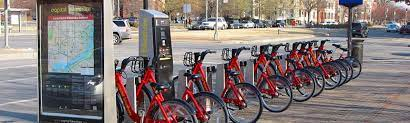

#**Table of Contents**
* Executive Summary (BLUF)
* Business Problem
* Metrics
* Libraries
* Data
* EDA & Data Preprocessing
* Extract Test Set & Standardize
* Develop Regressor MOdels
* Create Stacked Ensemble
* Performance on Test Data
* Conclusions

#**Executive Summary (BLUF)**
Developed a minimally-tuned stacked ensemble (featuring random forest and XGBoost regressors at the lowest-level, and an LGBMRegressor as metaregressor) to solve the Capital Bikeshare problem using a custom time series split crossvalidation strategy that produces an MSE on the most recent test data of around 7260. Visually, performance appears acceptable for automated (i.e., robotic) prediction. Better tuning of the metaregressor may improve performance.


#**Business Problem**

The following language was obtained from the Kaggle site:
"Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C."

#**Metrics**
We will use MSE as the primary metric, to target large prediction errors.

#**Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import pickle

In [ ]:
import xgboost as xgb
import lightgbm as lgb

In [ ]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit


In [ ]:
from datetime import datetime

#**Data**
From Kaggle:
- **datetime** - hourly date + timestamp  
- **season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter
- **holiday** - whether the day is considered a holiday
- **workingday** - whether the day is neither a weekend nor holiday
- **weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp** - temperature in Celsius
- **atemp** - "feels like" temperature in Celsius
- **humidity** - relative humidity
- **windspeed** - wind speed
- **casual** - number of non-registered user rentals initiated
- **registered** - number of registered user rentals initiated
- **count** - number of total rentals

In [ ]:
# Read Data - Code block added by Graeme Warren
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Read in Amazon One PLus Reviews Dataset
file_ = "drive/My Drive/Colab Notebooks/Big Data ML/New BDML/Data/bike_sharing_train.csv"   # adapt this as needed to the file structure on your Google drive
df=pd.read_csv(file_) # read in csv file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Shape
print(df.shape)
# Head
print(df.head())
# Info
print(df.info())
# Check for missing values
print('\n\nMissing Values\n',df.isnull().sum(axis=0))
# Check for duplicates
print('\n Duplicates\n',df.duplicated().sum())

(10886, 12)
              datetime  season  holiday  ...  casual  registered  count
0  2011-01-01 00:00:00       1        0  ...       3          13     16
1  2011-01-01 01:00:00       1        0  ...       8          32     40
2  2011-01-01 02:00:00       1        0  ...       5          27     32
3  2011-01-01 03:00:00       1        0  ...       3          10     13
4  2011-01-01 04:00:00       1        0  ...       0           1      1

[5 rows x 12 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed

In [ ]:
# Descriptive statistics
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


#**EDA & Data Preprocessing**

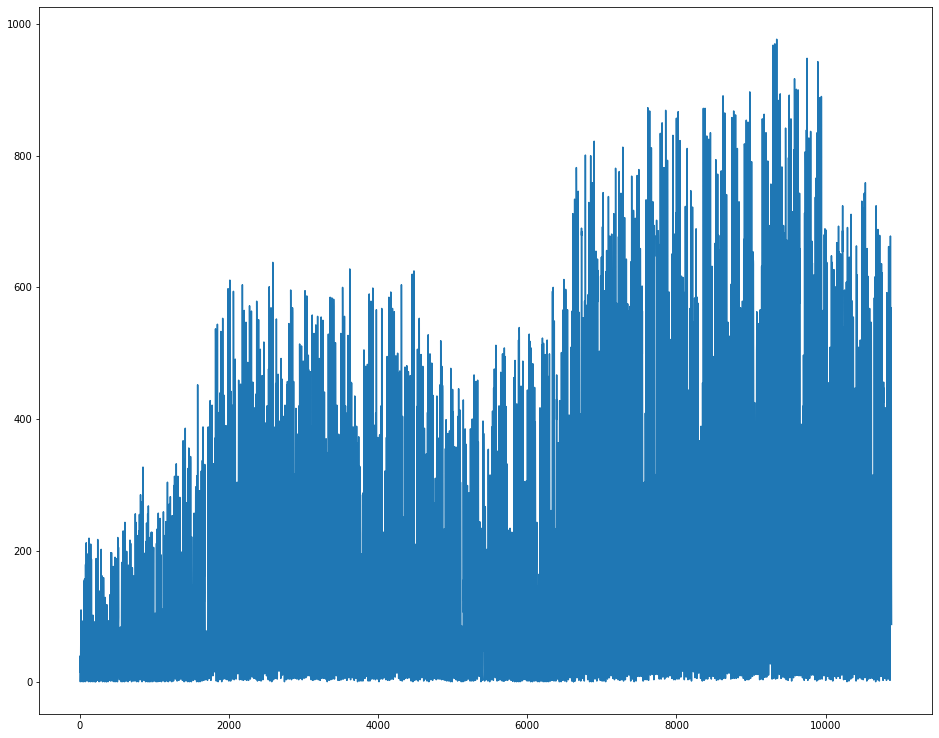

In [ ]:
#Line Chart of 'count'
plt.figure(figsize = (16,13))
df['count'].plot()
pyplot.show()

# Hard to interpret

In [ ]:
# Extract year, month and day from date feature
df['Weekday'] = pd.DatetimeIndex(df['datetime']).weekday
df['Month'] = pd.DatetimeIndex(df['datetime']).month
df['Year'] = pd.DatetimeIndex(df['datetime']).year
df['Hour'] = pd.DatetimeIndex(df['datetime']).hour
df.drop('datetime', axis=1, inplace=True)
df.head()


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Weekday,Month,Year,Hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,5,1,2011,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,5,1,2011,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,5,1,2011,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,5,1,2011,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,5,1,2011,4


In [ ]:
# Dop 'casual' and 'registered' (treating 'count' as the target)
df.drop(['casual','registered'], axis=1, inplace=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,Weekday,Month,Year,Hour
0,1,0,0,1,9.84,14.395,81,0.0,16,5,1,2011,0
1,1,0,0,1,9.02,13.635,80,0.0,40,5,1,2011,1
2,1,0,0,1,9.02,13.635,80,0.0,32,5,1,2011,2
3,1,0,0,1,9.84,14.395,75,0.0,13,5,1,2011,3
4,1,0,0,1,9.84,14.395,75,0.0,1,5,1,2011,4


In [ ]:
# Dummy encode 'weather' and 'season'
df=pd.get_dummies(data=df, columns=['weather','season'],drop_first=True)

In [ ]:
# Skewness
df[['temp', 'atemp', 'humidity', 'windspeed']].skew(axis = 0, skipna = True)  #Only need to check temp, atemp, himidity, windspeed. The other features are categorical

temp         0.003691
atemp       -0.102560
humidity    -0.086335
windspeed    0.588767
dtype: float64

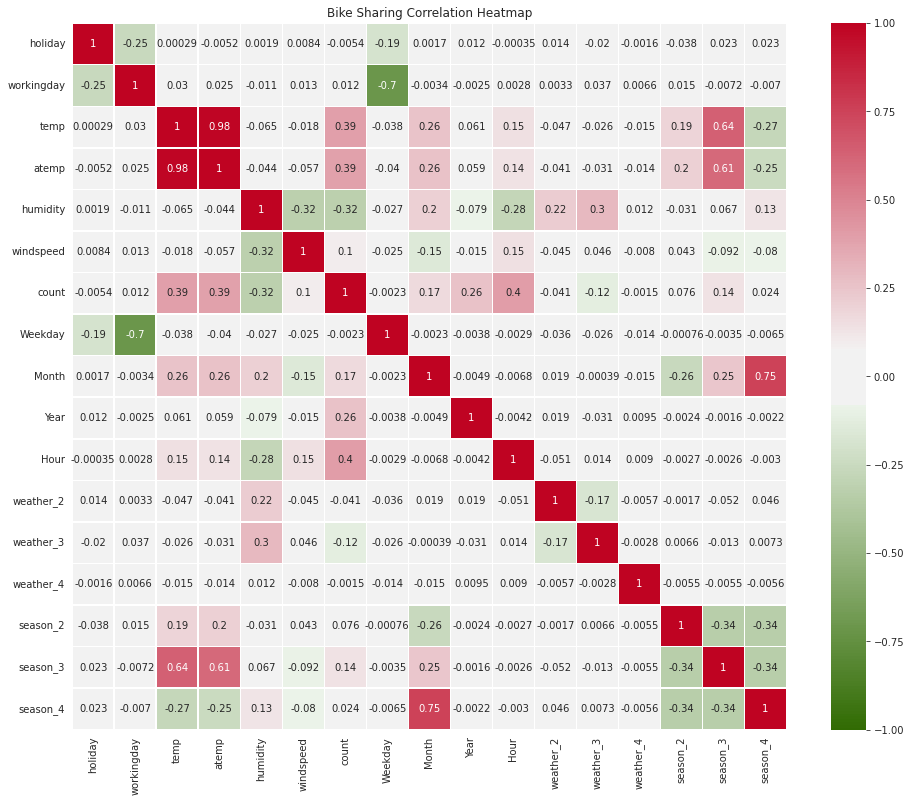

In [ ]:
# Correlation matrix to get a sense of predictor quality
sns.set_style('darkgrid')
plt.figure(figsize = (16,13))
cmap = sns.diverging_palette(120, 10, l = 40, s = 99, sep = 20, center = 'light', as_cmap = True)
sns.heatmap((df).corr(), vmin = -1, vmax = 1, annot = True, cmap = cmap, lw = .5, linecolor = 'white')
plt.title("Bike Sharing Correlation Heatmap")
plt.show()

#**Extract Test Set & Standardize**

In [ ]:
#Separate predictors X and target y
X = pd.DataFrame(df.drop(['count'],axis=1))
y = pd.DataFrame(df['count'])

In [ ]:
# Extract 10% youngest  of dataset as test data
test_size_ = round(0.1*len(X))
X_tr = X[:-test_size_]
y_tr = y[:-test_size_]
X_tst = X[-test_size_:]
y_tst = y[-test_size_:]



In [ ]:
# Standardize training and test data
stdsc1 = StandardScaler()
X_tr_std = stdsc1.fit_transform(X_tr)
X_tst_std = stdsc1.transform(X_tst)
stdsc2 = StandardScaler()
y_tr_std = stdsc2.fit_transform(y_tr)
y_tst_std = stdsc2.transform(y_tst)

#**Develop Regressor Models**

In [ ]:
tscv = TimeSeriesSplit(n_splits=4)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    # X_train, X_test = X[train_index], X[test_index]
    # y_train, y_test = y[train_index], y[test_index]

TRAIN: [   0    1    2 ... 2175 2176 2177] TEST: [2178 2179 2180 ... 4352 4353 4354]
TRAIN: [   0    1    2 ... 4352 4353 4354] TEST: [4355 4356 4357 ... 6529 6530 6531]
TRAIN: [   0    1    2 ... 6529 6530 6531] TEST: [6532 6533 6534 ... 8706 8707 8708]
TRAIN: [   0    1    2 ... 8706 8707 8708] TEST: [ 8709  8710  8711 ... 10883 10884 10885]


Image below ownloaded from [here](https://www.researchgate.net/publication/355889701_Predicting_the_Price_of_Crude_Oil_and_its_Fluctuations_Using_Computational_Econometrics_Deep_Learning_LSTM_and_Convolutional_Neural_Networks/figures?lo=1). Fair use claimed.

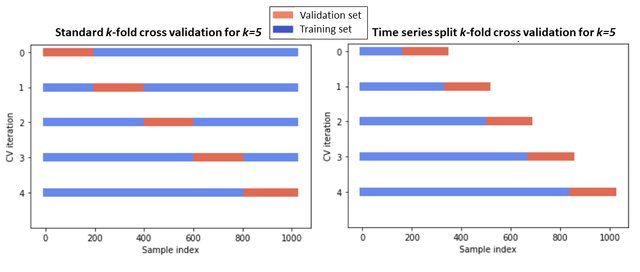

In [ ]:
# Random Forest
def random_forest(X,y):
    print('Random Forest:\n')
    params = {
     'max_depth':[10, 15, 20],
     'n_estimators': [200, 400]
    }
    rf_grid = GridSearchCV(RandomForestRegressor(),refit=True,
                            param_grid = params, scoring='neg_mean_squared_error', cv=tscv)
    rf_grid.fit(X,y)
    print('Best parameters: ',rf_grid.best_params_,' Best score: ',abs(rf_grid.best_score_))
    return rf_grid.best_estimator_

rf_model = random_forest(X_tr_std,np.ravel(y_tr_std))


Random Forest:

Best parameters:  {'max_depth': 20, 'n_estimators': 400}  Best score:  0.2114876453994999


In [ ]:
# XGBoost
def xgboost(X,y):
    print('XGBoost:\n')
    param = {'objective':'reg:squarederror',
             'learning_rate':0.1,
             'n_estimators':500,
             'gamma':0,
             'subsample': 0.8,
             'verbose':0,
             'reg_alpha':0,
             'max_depth':7,
             'min_child_weight':1,
             'colsample_bytree':0.5}
    param1 = {'max_depth':[7,15],
              'reg_alpha':[0.1,1,5],
              'learning_rate':[0.05,0.1]}
    xgb_grid = GridSearchCV(xgb.XGBRegressor(objective=param['objective'],
                              n_estimators=param['n_estimators'], learning_rate = param['learning_rate'], gamma=param['gamma'],
                              colsample_bytree=param['colsample_bytree'], subsample=param['subsample'], reg_alpha=param['reg_alpha']
                              ),
                            param_grid = param1, scoring='neg_mean_squared_error', cv=tscv    )
    xgb_grid.fit(X,y)
    print('Best parameters: ',xgb_grid.best_params_,' Best score: ',abs(xgb_grid.best_score_))
    return xgb_grid.best_estimator_

xgb_model = xgboost(X_tr_std,np.ravel(y_tr_std))


XGBoost:

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'reg_alpha': 1}  Best score:  0.19164982522352586


#**Create Stacked Ensemble**

In [ ]:
# Create a stacked ensemble of models
# It takes a LONG time to grid search all the parameter combinations listed in para_grid.

# define the base models
level0 = list()
level0.append(('RF', rf_model))
level0.append(('XGB', xgb_model))
# define meta learner model
level1 = lgb.LGBMRegressor(boosting_type='gbdt',  objective='regression', learning_rate=0.01, eval_metric='mse')
# define the stacking ensemble
ensemble = StackingRegressor(estimators=level0, final_estimator=level1)

param_grid = {
    #'final_estimator__num_leaves': [30, 60],
    #'final_estimator__reg_alpha': [0.1, 0.3],
    #'final_estimator__learning_rate': [0.01,0.1,0.5],
    'final_estimator__min_data_in_leaf': [30, 60, 90],
    #'final_estimator__lambda_l1': [0, 0.5, 1],
    #'final_estimator__lambda_l2': [0, 0.5, 1]
    }

gsearch = GridSearchCV(estimator=ensemble, param_grid=param_grid, cv=tscv)
gsearch.fit(X_tr_std, np.ravel(y_tr_std))
print("Best: %f using %s" % (gsearch.best_score_, gsearch.best_params_))
final_model = gsearch.best_estimator_

Best: 0.603968 using {'final_estimator__min_data_in_leaf': 30}


#**Performance on Test Data**




In [ ]:
# Prediction and reporting
y_pred_std = final_model.predict(X_tst_std)
y_pred_std = pd.DataFrame(y_pred_std)
y_pred = stdsc2.inverse_transform(y_pred_std)
print('MSE: %.2f ' % mean_squared_error(y_tst, y_pred))
print('MAE: %.2f ' % mean_absolute_error(y_tst,y_pred))
print('R^2: %.2f' % r2_score(y_tst, y_pred))

MSE: 7263.79 
MAE: 63.86 
R^2: 0.81


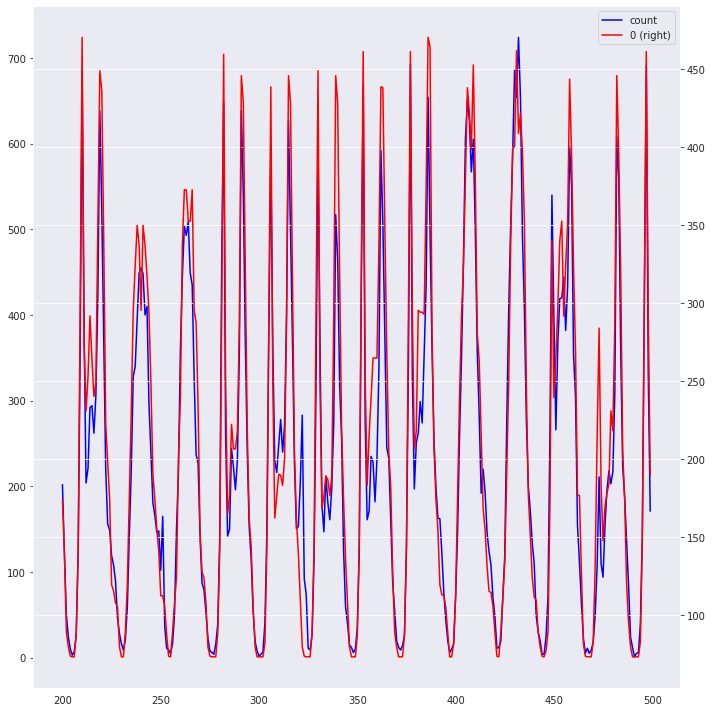

In [ ]:
#Line Chart of 'count'
y_tst=pd.DataFrame(y_tst)
y_pred=pd.DataFrame(y_pred)
y_tst = y_tst.set_index(y_pred.index)
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
ax = y_tst[200:500].plot(color='blue', label='Actuals')     # Adjust the slice (e.g., [200:500]) as needed to see petrformance on the whole test set
y_pred[200:500].plot(color='red', secondary_y=True, label='Predictions',ax=ax) # Adjust the slice (e.g., [200:500]) as needed to see performance on the whole test set
plt.show()

#**Conclusions**
Developed a minimally-tuned stacked ensemble (featuring random forest and XGBoost regressors at the lowest-level, and an LGBMRegressor as metaregressor) to solve the Capital Bikeshare problem using a custom time series split crossvalidation strategy that produces an MSE on the most recent test data of around 7260. Visually, performance appears acceptable for automated (i.e., robotic) prediction. Better tuning of the metaregressor may improve performance.
